In [1]:
from group_formations import get_xy_data_grouped_by_formation

xy_by_formation = get_xy_data_grouped_by_formation()

Processed home team for match: 1. FC Köln:FC Bayern München with lineup 4-2-3-1
Processed away team for match: 1. FC Köln:FC Bayern München with lineup 4-2-3-1
Processed home team for match: VfL Bochum 1848:Bayer 04 Leverkusen with lineup 4-3-3 Double-6
Processed away team for match: VfL Bochum 1848:Bayer 04 Leverkusen with lineup 4-2-3-1
Processed home team for match: Fortuna Düsseldorf:FC St. Pauli with lineup 3-4-1-2
Processed away team for match: Fortuna Düsseldorf:FC St. Pauli with lineup 3-3-2-2
Processed home team for match: Fortuna Düsseldorf:1. FC Kaiserslautern with lineup 4-4-2 Double-6 offensive Outliner
Processed away team for match: Fortuna Düsseldorf:1. FC Kaiserslautern with lineup 4-2-3-1
Processed home team for match: Fortuna Düsseldorf:1. FC Nürnberg with lineup 4-2-3-1
Processed away team for match: Fortuna Düsseldorf:1. FC Nürnberg with lineup 4-1-3-2
Processed home team for match: Fortuna Düsseldorf:SSV Jahn Regensburg with lineup 4-2-3-1
Processed away team for m

In [5]:
print("Formations:")
xy_by_formation.keys()

Formations:


dict_keys(['4-2-3-1', '4-3-3 Double-6', '3-4-1-2', '3-3-2-2', '4-4-2 Double-6 offensive Outliner', '4-1-3-2'])

In [15]:
import numpy as np

XY_3231 = xy_by_formation['4-2-3-1']
distinct_lens = {}
for xy in XY_3231:
    l = len(xy)
    if l in distinct_lens:
        distinct_lens[l] += 1
    else:
        distinct_lens[l] = 1

print(distinct_lens)

# temp fix, drop all frames with 24 players
XY_3231 = [xy for xy in XY_3231 if len(xy) == 22]
XY_3231 = np.array(XY_3231)

{22: 997513, 24: 145967}


Number of players: 11
Number of roles (K): 11
Number of bins (L): 294
Grid shape: (14, 21)
Reconstruction error: 0.1093

Player role assignments (dominant role per player):
[ 1  4  8  6  0 10 10  2  5  9  3]


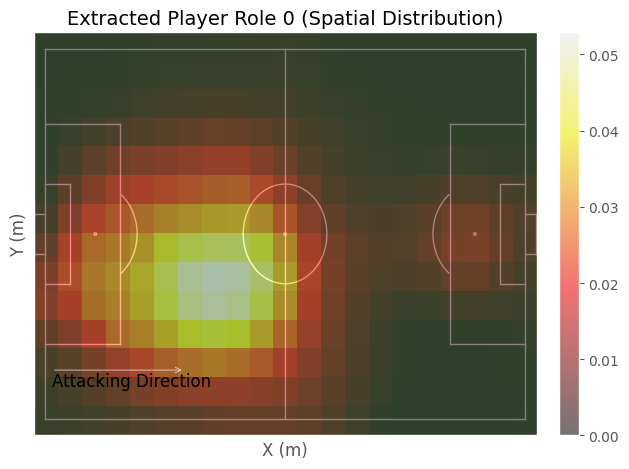

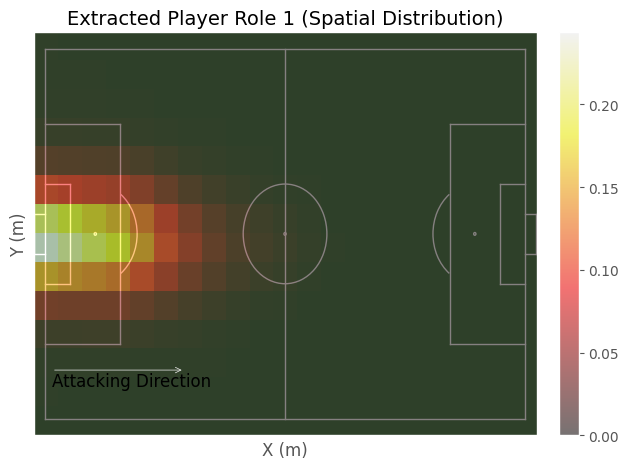

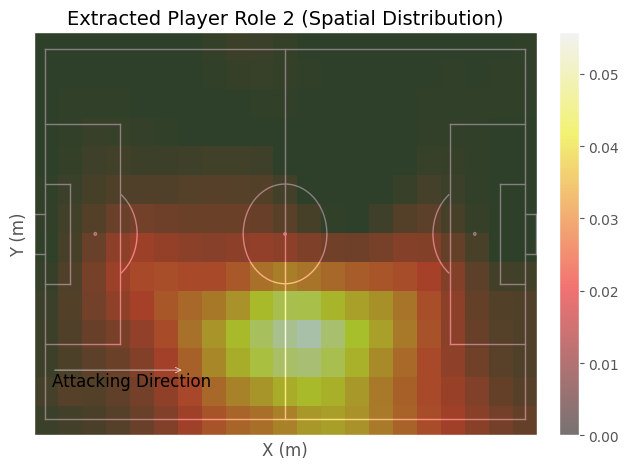

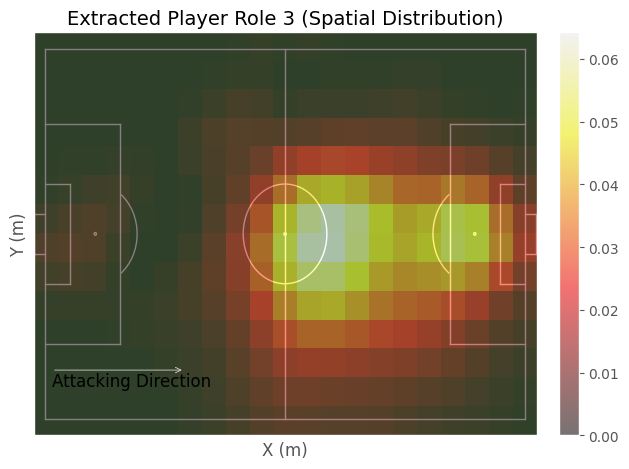

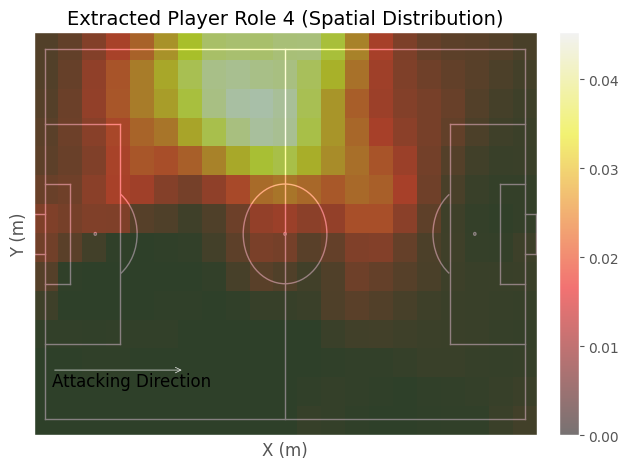

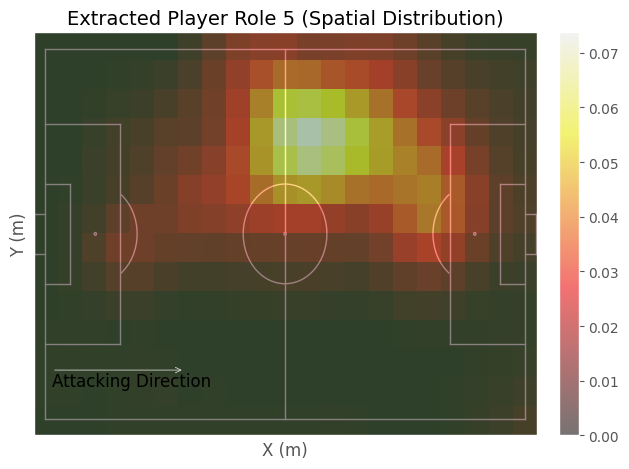

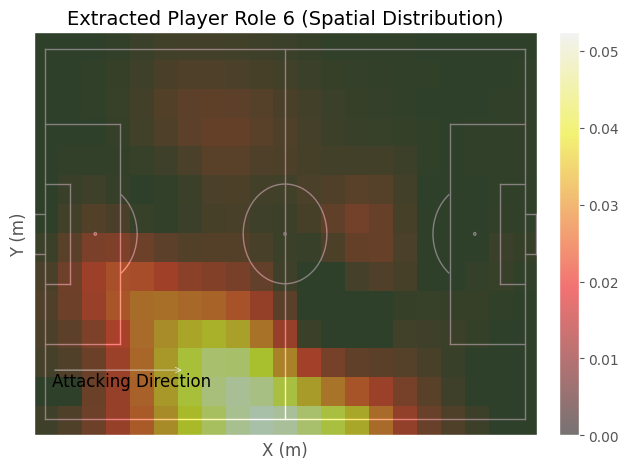

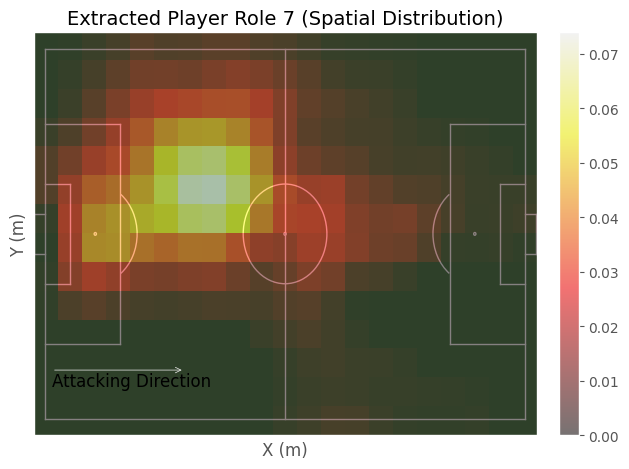

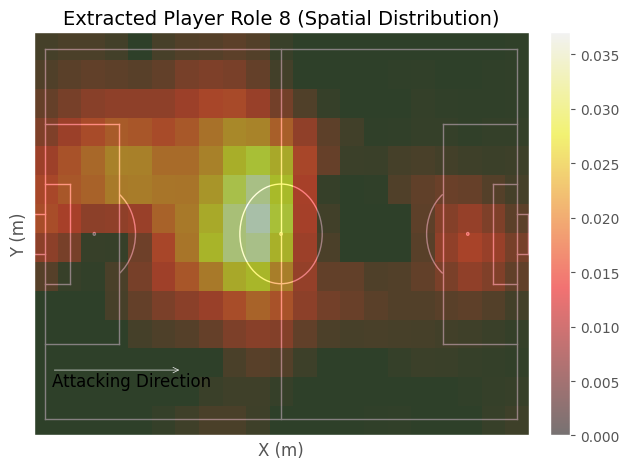

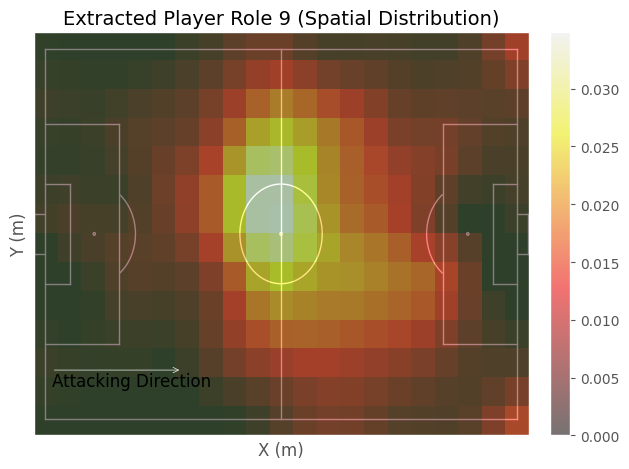

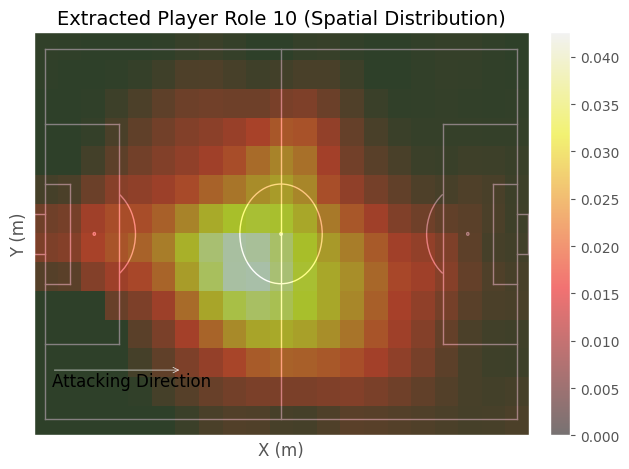

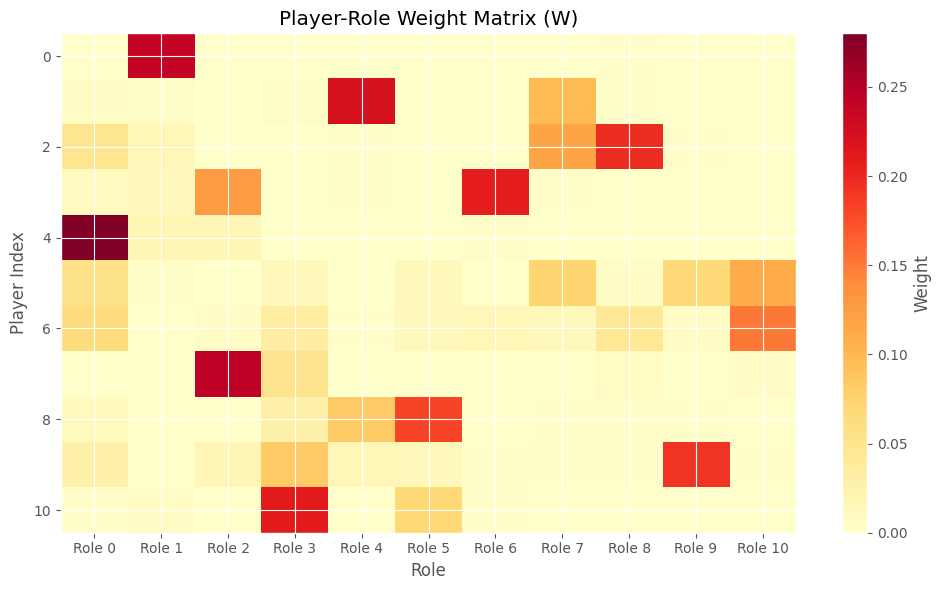

In [16]:
# TODO: Plot data for each formation
# Main cell for computing and aggregating player coordinates, per match formation
import os
import pandas as pd
import numpy as np
# Imports and deactivate warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from floodlight.io.dfl import read_position_data_xml, read_event_data_xml, read_teamsheets_from_mat_info_xml
from roles import extract_roles, get_role_heatmaps

from data_processing import display_data_summary, load_event_data, load_position_data
from visualization import load_data, plot_event_count, plot_kde, plot_goal_positions

path = "data/"
info_files = [x for x in os.listdir(path) if "matchinformation" in x]
position_files = [x for x in os.listdir(path) if "positions_raw" in x]
# Get any pitch attribute, for plotting
_, _, _, _, pitch = read_position_data_xml(os.path.join(path, position_files[0]), os.path.join(path, info_files[0]))

# Get the roles for each team
results = extract_roles(
    XY_3231,  # Convert DataFrame to numpy array
    pitch_xlim=(-52.5, 52.5),
    pitch_ylim=(-34.0, 34.0),
    bin_size=5.0,  # 5m x 5m bins as specified
    sigma=1.0,  # Gaussian smoothing parameter
    n_roles=11,  # Number of latent roles (adjustable)
    max_iter=500,
    random_state=42,
)

# Display results summary
print(f"Number of players: {results['n_players']}")
print(f"Number of roles (K): {results['n_roles']}")
print(f"Number of bins (L): {results['n_bins']}")
print(f"Grid shape: {results['grid_shape']}")
print(f"Reconstruction error: {results['reconstruction_error']:.4f}")
print(f"\nPlayer role assignments (dominant role per player):")
print(results['player_role_assignments'])


role_heatmaps = get_role_heatmaps(results['B'], results['grid_shape'])
n_roles = results['n_roles'] # Get the total number of roles

# Iterate through the heatmaps and plot each one in its own figure
for k, heatmap in enumerate(role_heatmaps):
    # Hardcoded limit values from y_lim and x_lim in Pitch
    x_min, x_max = -55, 55
    y_min, y_max = -37, 37
    # Custom cmap 
    original_cmap = plt.cm.get_cmap('hot') 
    transparent_cmap = original_cmap
    transparent_cmap.set_bad(color=(0, 0, 0, 0))
    
    fig, ax = plt.subplots() # Adjust figsize as needed for a single plot
    pitch.plot(ax=ax)
    ax.set_facecolor('#538053')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.annotate("Attacking Direction", xy=(-51, -25), xytext=(-51, -28), xycoords="data", fontsize=12)
    ax.annotate("", xy=(-22, -25), xytext=(-51, -25), xycoords="data",
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), ha="center", va="top")
    # The heatmap is plotted on top with alpha for transparency
    im = ax.imshow(heatmap, origin='lower', cmap=transparent_cmap, aspect='auto', alpha=0.5, 
                extent=(x_min, x_max, y_min, y_max))
    
    ax.set_title(f'Extracted Player Role {k} (Spatial Distribution)', fontsize=14)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')

    # 5. Add colorbar for this plot
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # 6. Adjust layout and show the individual figure
    plt.tight_layout()
    plt.show()


# Visualize player-role weight matrix (This part remains a single plot)
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(results['W'], cmap='YlOrRd', aspect='auto')
ax.set_xlabel('Role')
ax.set_ylabel('Player Index')
ax.set_title('Player-Role Weight Matrix (W)')
ax.set_xticks(range(results['n_roles']))
ax.set_xticklabels([f'Role {k}' for k in range(results['n_roles'])])
plt.colorbar(im, ax=ax, label='Weight')
plt.tight_layout()
plt.show()


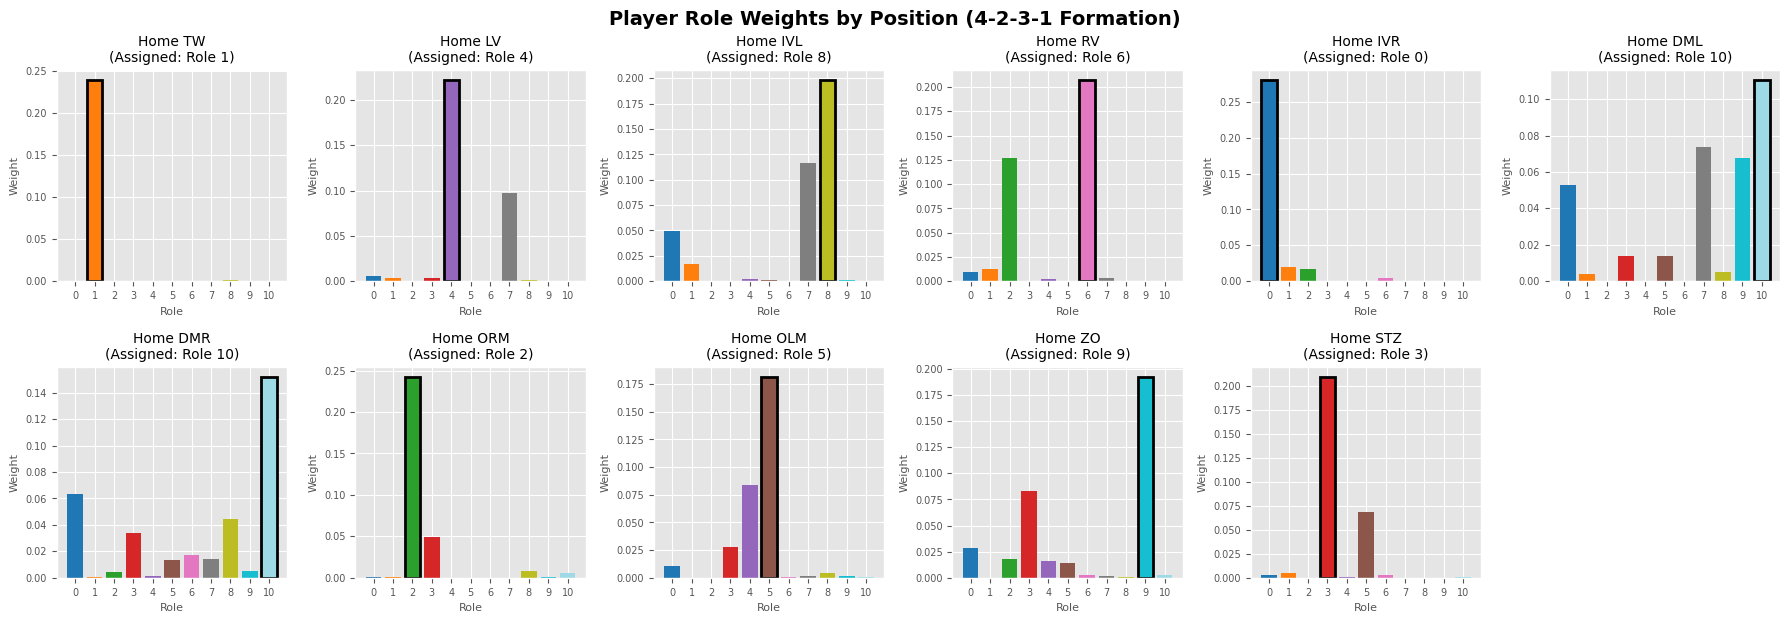


PLAYER ROLE ASSIGNMENT SUMMARY
Player Index    Position        Assigned Role   Max Weight     
------------------------------------------------------------
0               Home TW         1               0.2386         
1               Home LV         4               0.2216         
2               Home IVL        8               0.1980         
3               Home RV         6               0.2069         
4               Home IVR        0               0.2800         
5               Home DML        10              0.1103         
6               Home DMR        10              0.1518         
7               Home ORM        2               0.2424         
8               Home OLM        5               0.1814         
9               Home ZO         9               0.1923         
10              Home STZ        3               0.2097         


In [17]:
# Plot assigned roles for each player with their position labels
import matplotlib.pyplot as plt
import numpy as np

# Position labels for 4-2-3-1 formation (same order as in group_formations.py)
position_labels = ["TW", "LV", "IVL", "RV", "IVR", "DML", "DMR", "ORM", "OLM", "ZO", "STZ"]
# We have 22 players (11 per team), so duplicate labels for both teams
player_labels = [f"Home {pos}" for pos in position_labels] + [f"Away {pos}" for pos in position_labels]

# Get the weight matrix and role assignments
W = results['W']
n_players = results['n_players']
n_roles = results['n_roles']
player_role_assignments = results['player_role_assignments']

# Create a figure with subplots for each player
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(18, 12))
axes = axes.flatten()

# Color map for consistent role colors
colors = plt.cm.tab20(np.linspace(0, 1, n_roles))

for player_idx in range(min(n_players, 22)):  # Show up to 22 players
    ax = axes[player_idx]
    
    # Get role weights for this player
    role_weights = W[player_idx, :]
    dominant_role = player_role_assignments[player_idx]
    
    # Create bar plot
    bars = ax.bar(range(n_roles), role_weights, color=colors)
    
    # Highlight the dominant role
    bars[dominant_role].set_edgecolor('black')
    bars[dominant_role].set_linewidth(2)
    
    # Set labels
    ax.set_title(f'{player_labels[player_idx]}\n(Assigned: Role {dominant_role})', fontsize=10)
    ax.set_xlabel('Role', fontsize=8)
    ax.set_ylabel('Weight', fontsize=8)
    ax.set_xticks(range(n_roles))
    ax.set_xticklabels([str(k) for k in range(n_roles)], fontsize=7)
    ax.tick_params(axis='y', labelsize=7)

# Hide any unused subplots
for idx in range(n_players, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Player Role Weights by Position (4-2-3-1 Formation)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Create a summary table
print("\n" + "="*60)
print("PLAYER ROLE ASSIGNMENT SUMMARY")
print("="*60)
print(f"{'Player Index':<15} {'Position':<15} {'Assigned Role':<15} {'Max Weight':<15}")
print("-"*60)
for player_idx in range(n_players):
    pos = player_labels[player_idx] if player_idx < len(player_labels) else f"Player {player_idx}"
    assigned_role = player_role_assignments[player_idx]
    max_weight = W[player_idx, assigned_role]
    print(f"{player_idx:<15} {pos:<15} {assigned_role:<15} {max_weight:<15.4f}")


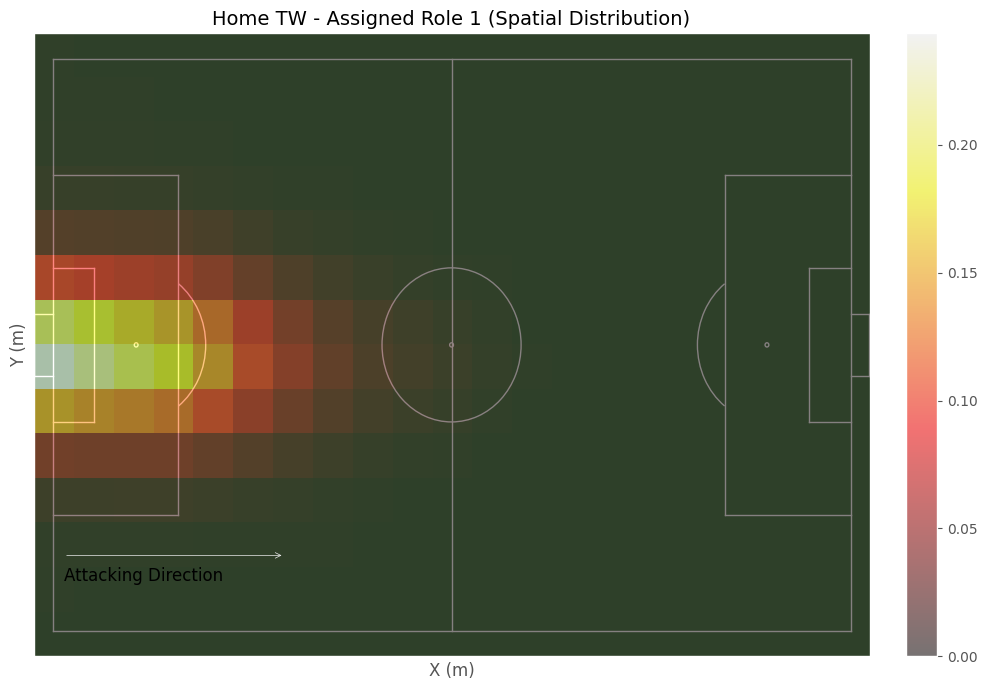

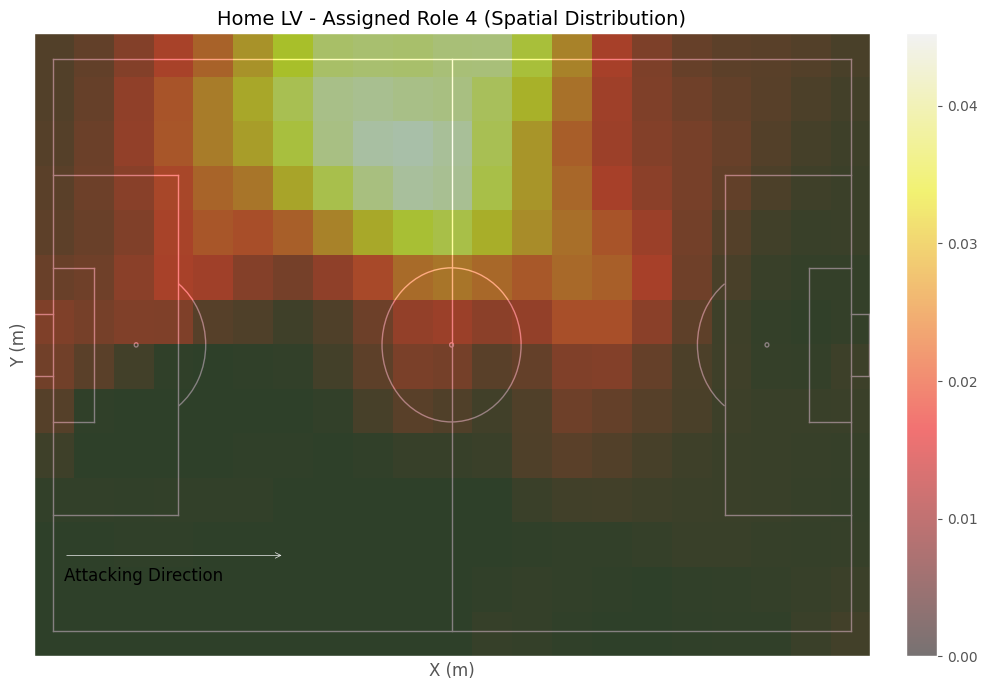

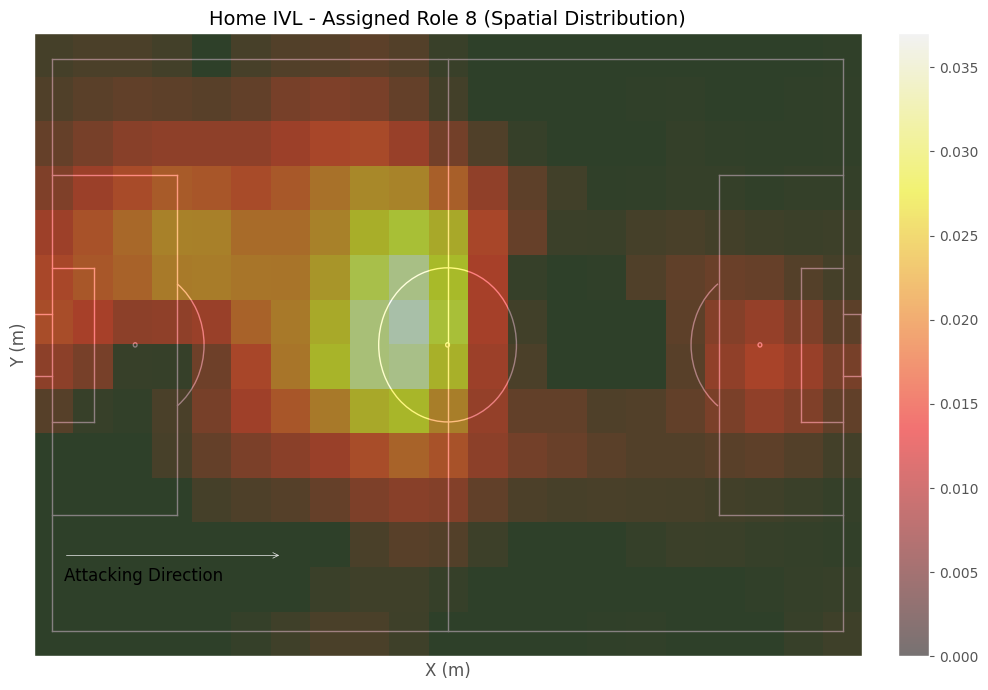

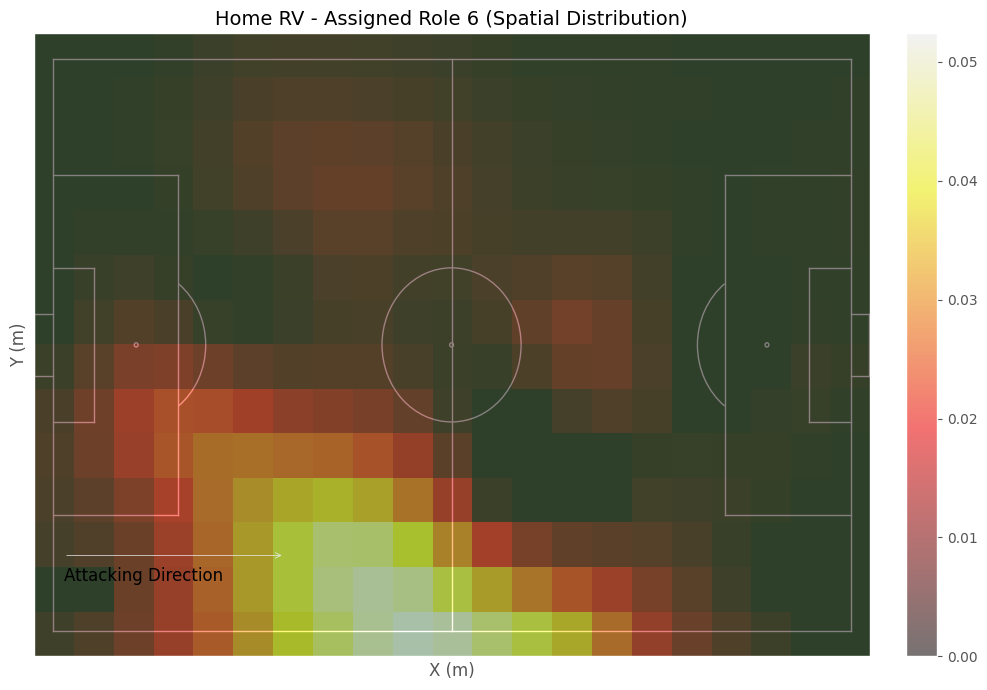

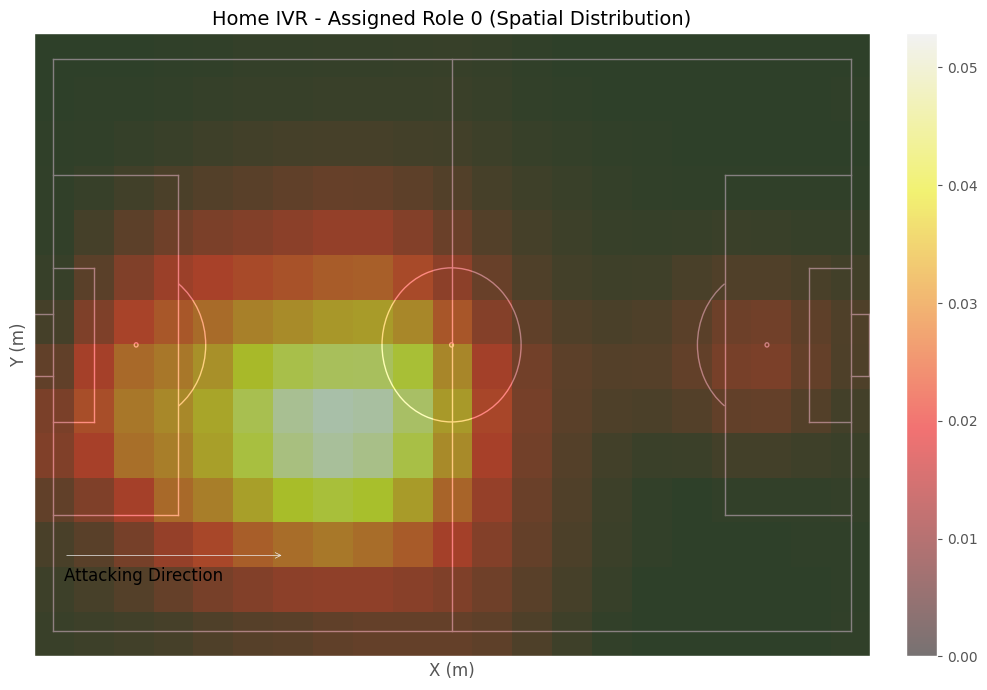

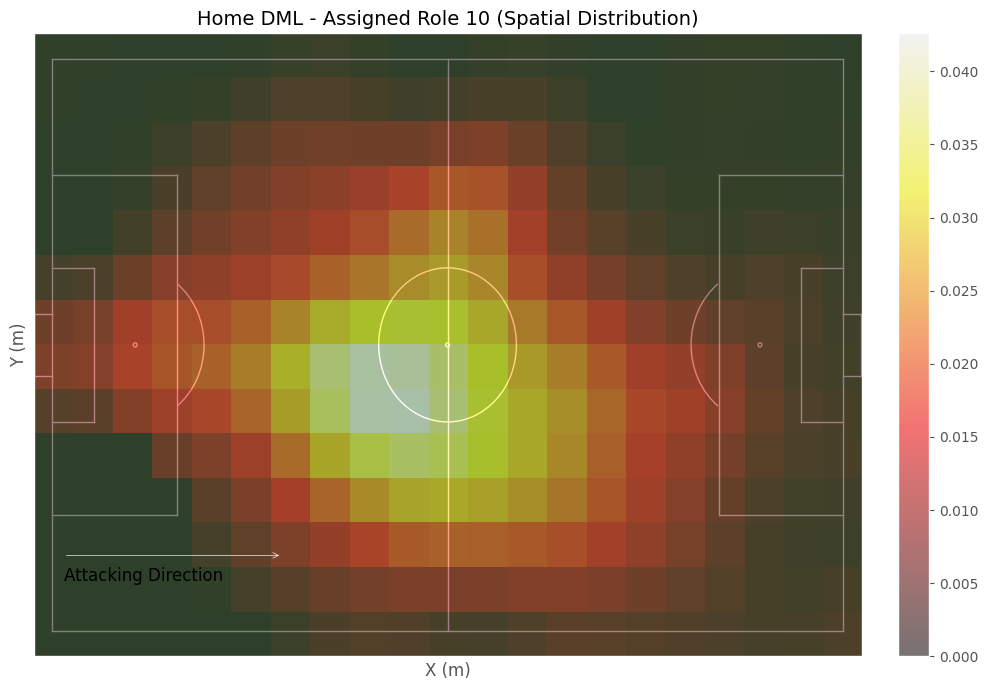

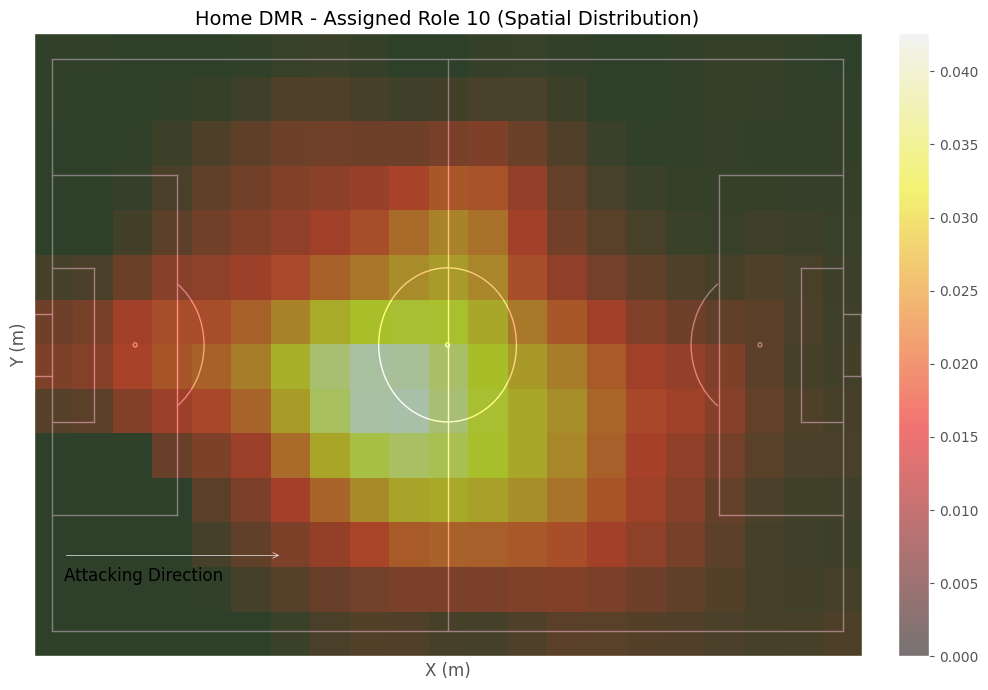

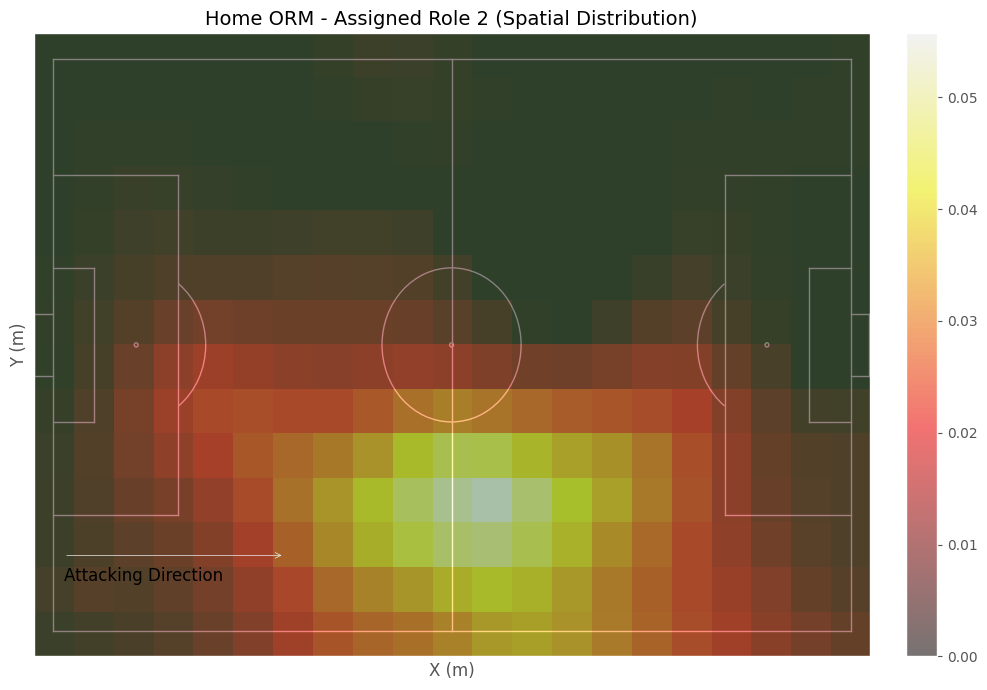

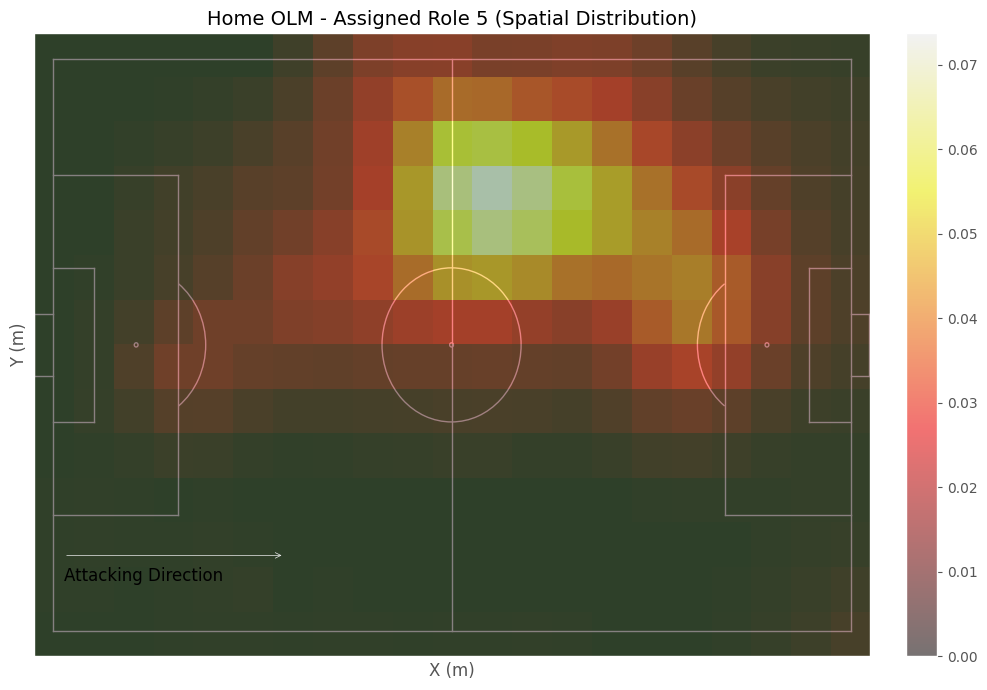

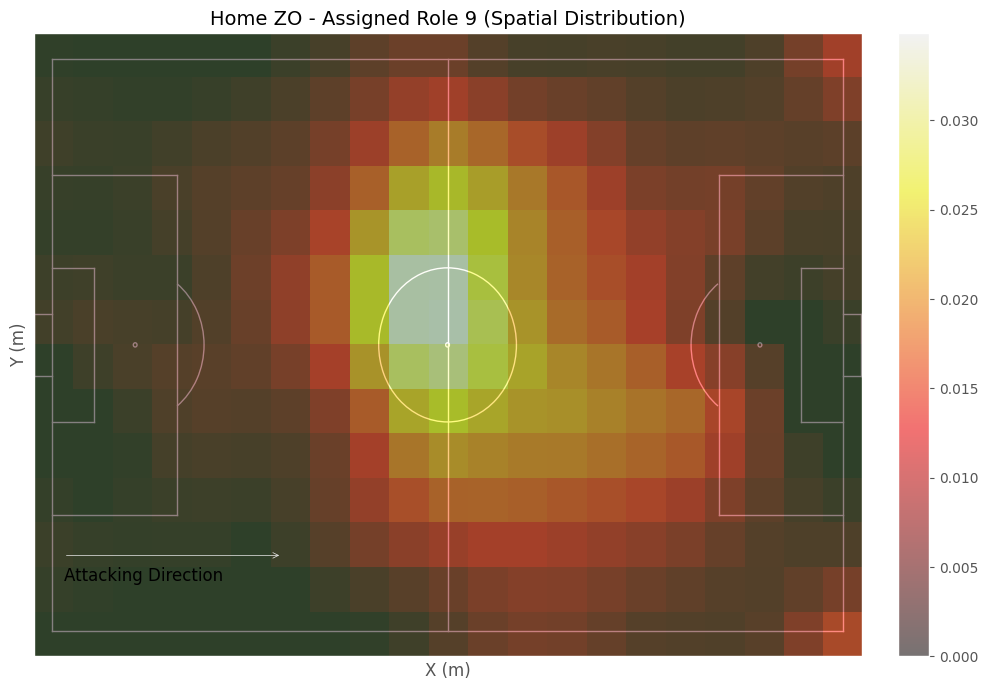

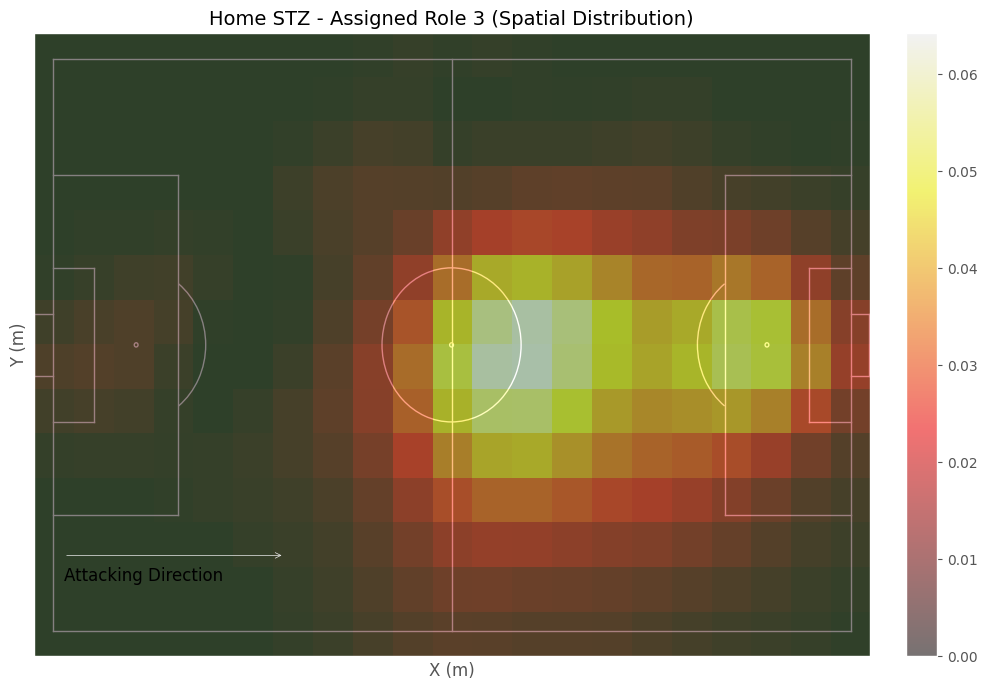

In [18]:
# Plot the top assigned role heatmap for each player with their position in the title
role_heatmaps = get_role_heatmaps(results['B'], results['grid_shape'])

# Position labels for 4-2-3-1 formation
position_labels = ["TW", "LV", "IVL", "RV", "IVR", "DML", "DMR", "ORM", "OLM", "ZO", "STZ"]
player_labels = [f"Home {pos}" for pos in position_labels] + [f"Away {pos}" for pos in position_labels]

# Iterate through each player and plot their top role heatmap
for player_idx in range(min(results['n_players'], 22)):
    # Get the dominant role for this player
    dominant_role = results['player_role_assignments'][player_idx]
    heatmap = role_heatmaps[dominant_role]
    
    # Get player position label
    player_pos = player_labels[player_idx] if player_idx < len(player_labels) else f"Player {player_idx}"
    
    # Hardcoded limit values from y_lim and x_lim in Pitch
    x_min, x_max = -55, 55
    y_min, y_max = -37, 37
    
    # Custom cmap 
    original_cmap = plt.cm.get_cmap('hot') 
    transparent_cmap = original_cmap
    transparent_cmap.set_bad(color=(0, 0, 0, 0))
    
    fig, ax = plt.subplots(figsize=(10, 7))
    pitch.plot(ax=ax)
    ax.set_facecolor('#538053')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.annotate("Attacking Direction", xy=(-51, -25), xytext=(-51, -28), xycoords="data", fontsize=12)
    ax.annotate("", xy=(-22, -25), xytext=(-51, -25), xycoords="data",
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), ha="center", va="top")
    
    # The heatmap is plotted on top with alpha for transparency
    im = ax.imshow(heatmap, origin='lower', cmap=transparent_cmap, aspect='auto', alpha=0.5, 
                extent=(x_min, x_max, y_min, y_max))
    
    ax.set_title(f'{player_pos} - Assigned Role {dominant_role} (Spatial Distribution)', fontsize=14)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')

    # Add colorbar for this plot
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Adjust layout and show the individual figure
    plt.tight_layout()
    plt.show()
